In [1]:
## PRELIMINARIES ##
%load_ext autoreload
%autoreload 2

from IPython.display import HTML
from IPython.display import Javascript
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
# Python imports
import sys
sys.path.append('../')
import glob

In [3]:
# Rankutils imports
from rankutils.cfgloader import *
from rankutils.utilities import safe_create_dir, completedir, getbasename
from rankutils.rIO import read_rank
from rankutils.statistical import diff_break_clustering
from rankutils.drawing import colors_from_cmap

In [4]:
# Other imports
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
import mpld3
from sklearn.preprocessing import MinMaxScaler

In [5]:
# Matlab - We will start it later
import matlab.engine

In [6]:
# Few definitions
min_tail_size = 5
pathcfg = cfgloader('../path_2.cfg')
minmaxscaler = MinMaxScaler((0, 1))

## Plotting Comparison Experiment

In [7]:
rkfpath_a = '/home/alberto/phD/temp/rkfiles/places/airfield_00004927.jpg.rk'
rkname_a = getbasename(rkfpath_a)

rkfpath_b = '/home/alberto/phD/temp/rkfiles/places/hangar_outdoor_00004852.jpg.rk'
rkname_b = getbasename(rkfpath_b)

score_type = 'dists'
k = 10
l = -1

scl = False
cvt = False

In [8]:
rka = read_rank(rkfpath_a, score_type)
rkb = read_rank(rkfpath_b, score_type)

if l > 0:
    rka = rka[0:l]
    rkb = rkb[0:l]

if rka[0] == 0:
    rka = rka[1:]
if rkb[0] == 0:
    rkb = rkb[1:]
    
if scl:
    rka = minmaxscaler.fit_transform(rka.reshape(-1, 1)).reshape(-1)
    rkb = minmaxscaler.fit_transform(rkb.reshape(-1, 1)).reshape(-1)
    
if cvt:
    rka = np.max(rka) - rka
    rkb = np.max(rkb) - rkb
    
# Lower and Upper bounds
lba = np.min(rka)
uba = np.max(rka)

lbb = np.min(rkb)
ubb = np.max(rkb)

lowerb = np.min([[lba, lbb]])
upperb = np.min([[uba, ubb]])

In [9]:
hista, edgesa = np.histogram(rka[k:], bins=64, density=True)
histb, edgesb = np.histogram(rkb[k:], bins=64, density=True)

In [10]:
matlab_engine = matlab.engine.start_matlab()

In [11]:
tla = rka[k:]
tlb = rkb[k:]

dataa = matlab.double(tla[tla != 0].reshape(-1).tolist())
datab = matlab.double(tlb[tlb != 0].reshape(-1).tolist())

# Weibull Fitting
estpar, _ = matlab_engine.wblfit(dataa, nargout=2)
wbla = dict(scale=estpar[0][0], shape=estpar[0][1], loc=0)

estpar, _ = matlab_engine.wblfit(datab, nargout=2)
wblb = dict(scale=estpar[0][0], shape=estpar[0][1], loc=0)

# GEV Fitting
estpar, _ = matlab_engine.gevfit(dataa, nargout=2)
geva = dict(scale=estpar[0][1], shape=estpar[0][0], loc=estpar[0][2])

estpar, _ = matlab_engine.gevfit(datab, nargout=2)
gevb = dict(scale=estpar[0][1], shape=estpar[0][0], loc=estpar[0][2])

In [12]:
# PDF - Interval is {0, max*1.5}
xa = matlab.double(np.linspace(0, np.floor(edgesa[-1]*1.5), 10000).reshape(-1).tolist())
xb = matlab.double(np.linspace(0, np.floor(edgesb[-1]*1.5), 10000).reshape(-1).tolist())

wbla['pdf'] = np.array(matlab_engine.wblpdf(xa, wbla['scale'], wbla['shape']), dtype=np.float64).reshape(-1)
wblb['pdf'] = np.array(matlab_engine.wblpdf(xb, wblb['scale'], wblb['shape']), dtype=np.float64).reshape(-1)

geva['pdf'] = np.array(matlab_engine.gevpdf(xa, geva['shape'], geva['scale'], geva['loc']), dtype=np.float64).reshape(-1)
gevb['pdf'] = np.array(matlab_engine.gevpdf(xb, gevb['shape'], gevb['scale'], gevb['loc']), dtype=np.float64).reshape(-1)


# CDF - Interval is {min, max}
x_cdf = matlab.double(np.linspace(lowerb, upperb, 10000).reshape(-1).tolist())
wbla['cdf'] = np.array(matlab_engine.wblcdf(x_cdf, wbla['scale'], wbla['shape']), dtype=np.float64).reshape(-1)
wblb['cdf'] = np.array(matlab_engine.wblcdf(x_cdf, wblb['scale'], wblb['shape']), dtype=np.float64).reshape(-1)

geva['cdf'] = np.array(matlab_engine.gevcdf(x_cdf, geva['shape'], geva['scale'], geva['loc']), dtype=np.float64).reshape(-1)
gevb['cdf'] = np.array(matlab_engine.gevcdf(x_cdf, gevb['shape'], gevb['scale'], gevb['loc']), dtype=np.float64).reshape(-1)


# Inverse CDF - Interval is {0, 1}
x_inv = matlab.double(np.linspace(0, 1, 10000).reshape(-1).tolist())
wbla['inv'] = np.array(matlab_engine.wblinv(x_inv, wbla['scale'], wbla['shape']), dtype=np.float64).reshape(-1)
wblb['inv'] = np.array(matlab_engine.wblinv(x_inv, wblb['scale'], wblb['shape']), dtype=np.float64).reshape(-1)

geva['inv'] = np.array(matlab_engine.gevinv(x_inv, geva['shape'], geva['scale'], geva['loc']), dtype=np.float64).reshape(-1)
gevb['inv'] = np.array(matlab_engine.gevinv(x_inv, gevb['shape'], gevb['scale'], gevb['loc']), dtype=np.float64).reshape(-1)

### Density Histogram

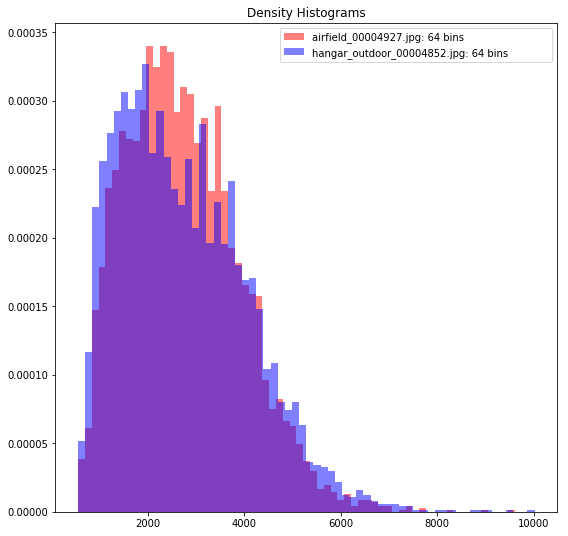

In [13]:
plt.close()

fig, ax = plt.subplots(1)
fig.set_size_inches(9, 9)

# To compute the width of each bar, we use the distance between the limits of the two first bins
ax.bar(edgesa[0:-1], hista, edgesa[1]-edgesa[0], 0.0, align='edge', color='red', 
       alpha=0.5, label='{0:s}: {1:d} bins             '.format(rkname_a, hista.size))

ax.bar(edgesb[0:-1], histb, edgesb[1]-edgesb[0], 0.0, align='edge', color='blue',
       alpha=0.5, label='{0:s}: {1:d} bins             '.format(rkname_b, histb.size))

ax.set_title('Density Histograms')

ax.legend()

mpld3.enable_notebook()

### Weibull

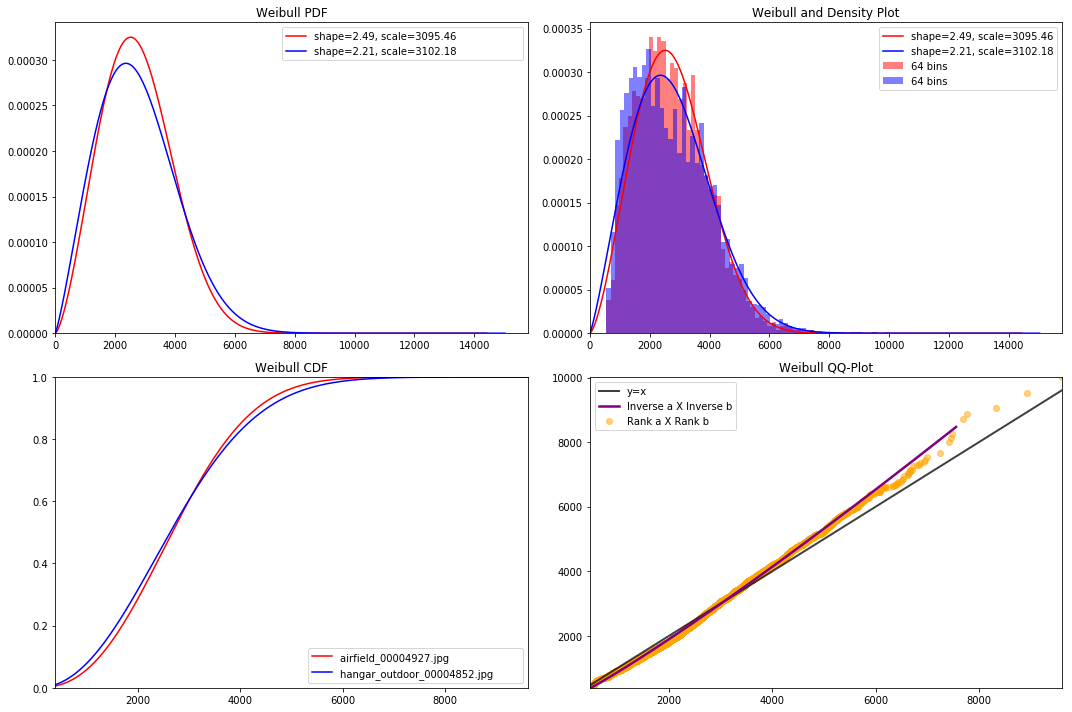

In [14]:
plt.close()

fig, axes = plt.subplots(2, 2)
ax0, ax1 = axes[0]
ax2, ax3 = axes[1]
fig.set_size_inches(15, 10)

# Weibull PDF
ax0.plot(np.array(xa).reshape(-1), wbla['pdf'], color='red', linewidth=1.5,
        label='shape={0:0.2f}, scale={1:0.2f}                    '
         .format(wbla['shape'], wbla['scale']))

ax0.plot(np.array(xb).reshape(-1), wblb['pdf'], color='blue', linewidth=1.5,
        label='shape={0:0.2f}, scale={1:0.2f}                   '
         .format(wblb['shape'], wblb['scale']))

ax0.set_title('Weibull PDF')
ax0.set_xlim(left=0)
ax0.set_ylim(bottom=0)

ax0.legend()

# Weibull and Density Superimposed
ax1.plot(np.array(xa).reshape(-1), wbla['pdf'], color='red', linewidth=1.5,
        label='shape={0:0.2f}, scale={1:0.2f}'.format(wbla['shape'], wbla['scale']))

ax1.bar(edgesa[0:-1], hista, edgesa[1]-edgesa[0], 0.0, align='edge', color='red', 
       alpha=0.5, label='{0:d} bins'.format(hista.size))


ax1.plot(np.array(xb).reshape(-1), wblb['pdf'], color='blue', linewidth=1.5,
        label='shape={0:0.2f}, scale={1:0.2f}'.format(wblb['shape'], wblb['scale']))

ax1.bar(edgesb[0:-1], histb, edgesb[1]-edgesb[0], 0.0, align='edge', color='blue',
       alpha=0.5, label='{0:d} bins'.format(histb.size))

ax1.set_title('Weibull and Density Plot')
ax1.set_xlim(left=0)
ax1.set_ylim(bottom=0)

ax1.legend()

# Weibull CDF

ax2.plot(np.array(x_cdf).reshape(-1), wbla['cdf'], color='red', linewidth=1.5,
        label='{0:s}        '.format(rkname_a))

ax2.plot(np.array(x_cdf).reshape(-1), wblb['cdf'], color='blue', linewidth=1.5,
        label='{0:s}        '.format(rkname_b))

ax2.set_title('Weibull CDF')
ax2.set_xlim(left=lowerb, right=upperb)
ax2.set_ylim(bottom=0, top=1)

ax2.legend()

# QQ Plot

yx = np.linspace(np.min([lba, lbb]), np.max([uba, ubb]), 1000)

ax3.plot(yx, yx, color='black', linewidth=2.0, label='y=x', alpha=0.75)
ax3.plot(wbla['inv'], wblb['inv'], color='purple', linewidth=2.5, label='Inverse a X Inverse b')
ax3.scatter(rka, rkb, color='orange', alpha=0.5, label='Rank a X Rank b')

ax3.set_title('Weibull QQ-Plot')
ax3.set_xlim(left=lba, right=uba)
ax3.set_ylim(bottom=lbb, top=ubb)

ax3.legend()

plt.tight_layout()

mpld3.disable_notebook()

### Generalized Extreme Value

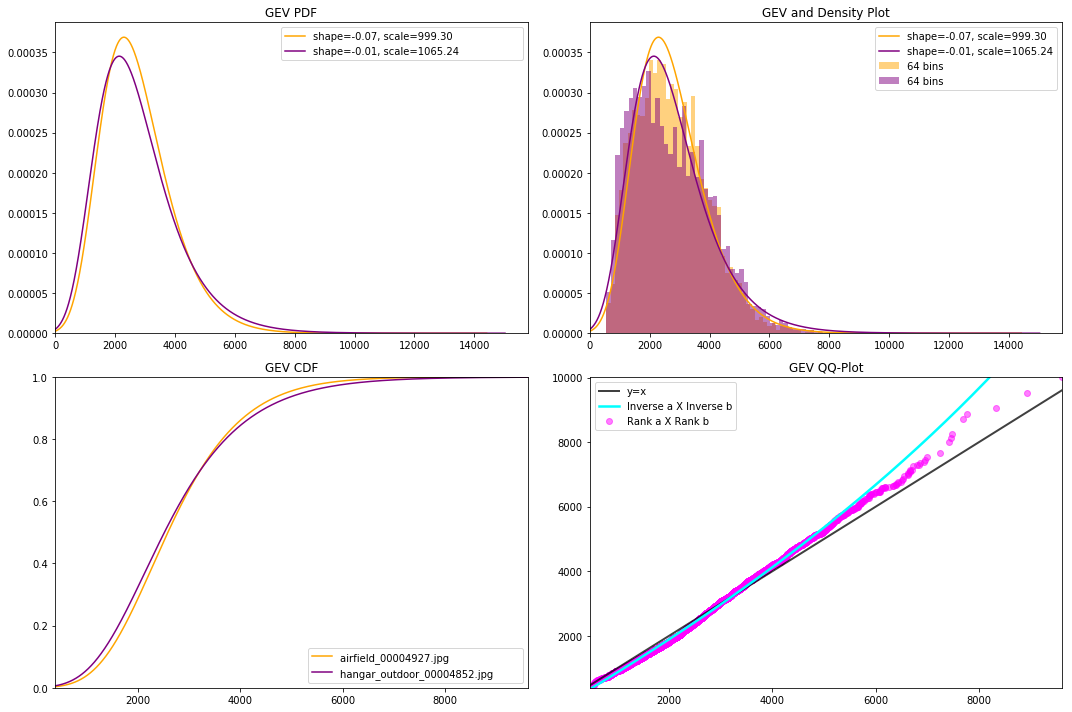

In [15]:
plt.close()

fig, axes = plt.subplots(2, 2)
ax0, ax1 = axes[0]
ax2, ax3 = axes[1]
fig.set_size_inches(15, 10)

# Weibull PDF
ax0.plot(np.array(xa).reshape(-1), geva['pdf'], color='orange', linewidth=1.5,
        label='shape={0:0.2f}, scale={1:0.2f}                    '
         .format(geva['shape'], geva['scale']))

ax0.plot(np.array(xb).reshape(-1), gevb['pdf'], color='purple', linewidth=1.5,
        label='shape={0:0.2f}, scale={1:0.2f}                   '
         .format(gevb['shape'], gevb['scale']))

ax0.set_title('GEV PDF')
ax0.set_xlim(left=0)
ax0.set_ylim(bottom=0)

ax0.legend()

# Weibull and Density Superimposed
ax1.plot(np.array(xa).reshape(-1), geva['pdf'], color='orange', linewidth=1.5,
        label='shape={0:0.2f}, scale={1:0.2f}'.format(geva['shape'], geva['scale']))

ax1.bar(edgesa[0:-1], hista, edgesa[1]-edgesa[0], 0.0, align='edge', color='orange', 
       alpha=0.5, label='{0:d} bins'.format(hista.size))


ax1.plot(np.array(xb).reshape(-1), gevb['pdf'], color='purple', linewidth=1.5,
        label='shape={0:0.2f}, scale={1:0.2f}'.format(gevb['shape'], gevb['scale']))

ax1.bar(edgesb[0:-1], histb, edgesb[1]-edgesb[0], 0.0, align='edge', color='purple',
       alpha=0.5, label='{0:d} bins'.format(histb.size))

ax1.set_title('GEV and Density Plot')
ax1.set_xlim(left=0)
ax1.set_ylim(bottom=0)

ax1.legend()

# GEV CDF
ax2.plot(np.array(x_cdf).reshape(-1), geva['cdf'], color='orange', linewidth=1.5,
        label='{0:s}        '.format(rkname_a))

ax2.plot(np.array(x_cdf).reshape(-1), gevb['cdf'], color='purple', linewidth=1.5,
        label='{0:s}        '.format(rkname_b))

ax2.set_title('GEV CDF')
ax2.set_xlim(left=lowerb, right=upperb)
ax2.set_ylim(bottom=0, top=1)

ax2.legend()

# QQ Plot

# Lower and Upper bounds
lba = np.min(rka)
uba = np.max(rka)

lbb = np.min(rkb)
ubb = np.max(rkb)

yx = np.linspace(np.min([lba, lbb]), np.max([uba, ubb]), 1000)

ax3.plot(yx, yx, color='black', linewidth=2.0, label='y=x', alpha=0.75)
ax3.plot(geva['inv'], gevb['inv'], color='cyan', linewidth=2.5, label='Inverse a X Inverse b')
ax3.scatter(rka, rkb, color='magenta', alpha=0.5, label='Rank a X Rank b')

ax3.set_title('GEV QQ-Plot')
ax3.set_xlim(left=lba, right=uba)
ax3.set_ylim(bottom=lbb, top=ubb)

ax3.legend()

plt.tight_layout()

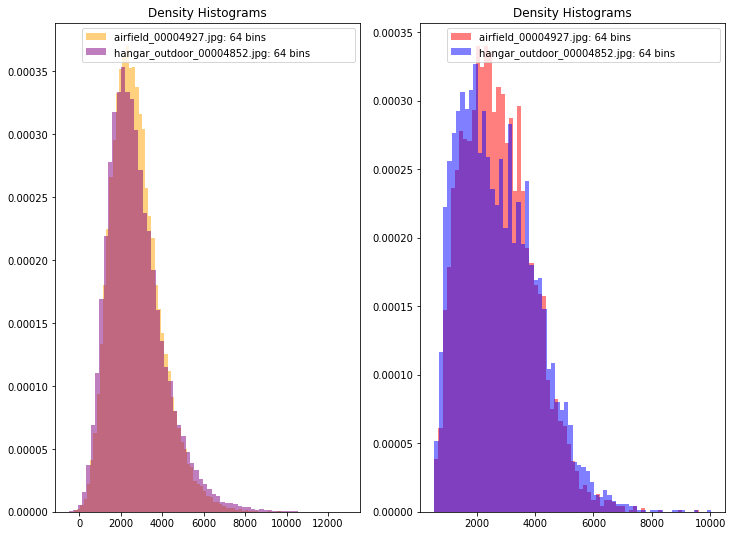

In [16]:
samplea = np.array(matlab_engine.gevrnd(geva['shape'], geva['scale'], geva['loc'], 50000, 1)).reshape(-1)
sampleb = np.array(matlab_engine.gevrnd(gevb['shape'], gevb['scale'], gevb['loc'], 50000, 1)).reshape(-1)

s_hista, s_edgesa = np.histogram(samplea, bins=64, density=True)
s_histb, s_edgesb = np.histogram(sampleb, bins=64, density=True)

plt.close()

fig, axes = plt.subplots(1, 2)
ax0, ax1 = axes
fig.set_size_inches(12, 9)

# To compute the width of each bar, we use the distance between the limits of the two first bins
ax0.bar(s_edgesa[0:-1], s_hista, s_edgesa[1]-s_edgesa[0], 0.0, align='edge', color='orange', 
       alpha=0.5, label='{0:s}: {1:d} bins             '.format(rkname_a, s_hista.size))

ax0.bar(s_edgesb[0:-1], s_histb, s_edgesb[1]-s_edgesb[0], 0.0, align='edge', color='purple',
       alpha=0.5, label='{0:s}: {1:d} bins             '.format(rkname_b, s_histb.size))

ax0.set_title('Density Histograms')

ax0.legend()

# To compute the width of each bar, we use the distance between the limits of the two first bins
ax1.bar(edgesa[0:-1], hista, edgesa[1]-edgesa[0], 0.0, align='edge', color='red', 
       alpha=0.5, label='{0:s}: {1:d} bins             '.format(rkname_a, hista.size))

ax1.bar(edgesb[0:-1], histb, edgesb[1]-edgesb[0], 0.0, align='edge', color='blue',
       alpha=0.5, label='{0:s}: {1:d} bins             '.format(rkname_b, histb.size))

ax1.set_title('Density Histograms')

ax1.legend()

mpld3.enable_notebook()

In [17]:
print("sum hist a = ", np.sum(s_hista))
print("sum hist b = ", np.sum(s_histb), '\n')

bsa = np.abs(s_edgesa[1] - s_edgesa[0])
bsb = np.abs(s_edgesb[1] - s_edgesb[0])

pa = bsa*s_hista
pb = bsb*s_histb

sum_pa = np.sum(bsa*s_hista)
sum_pb = np.sum(bsb*s_histb)

np.set_printoptions(precision=8, linewidth=300)

print("Pb: ", pa)
print("   -> Sum(Pa) = {0:f}".format(sum_pa), '\n')

print("Pb: ", pb)
print("   -> Sum(Pb) = {0:f}".format(sum_pb), '\n')

KLD = stats.entropy(pa, pb, base=2)
print("KLD = ", KLD)

EMD = stats.wasserstein_distance(pa, pb)
print("{0:s} x {1:s} -> EMD = {2:0.6f}".format(rkname_a, rkname_b, EMD))

sum hist a =  0.006417746636883858
sum hist b =  0.0047919833143867056 

Pb:  [2.200e-04 4.000e-04 8.600e-04 1.640e-03 3.500e-03 6.380e-03 9.720e-03 1.454e-02 2.080e-02 2.802e-02 3.504e-02 4.144e-02 4.606e-02 5.184e-02 5.476e-02 5.658e-02 5.768e-02 5.498e-02 5.508e-02 5.254e-02 4.924e-02 4.734e-02 4.014e-02 3.664e-02 3.390e-02 2.806e-02 2.510e-02 2.218e-02 1.956e-02
 1.740e-02 1.426e-02 1.248e-02 1.032e-02 8.700e-03 7.780e-03 5.900e-03 5.500e-03 3.800e-03 3.440e-03 3.140e-03 2.540e-03 1.900e-03 1.840e-03 1.180e-03 1.240e-03 9.600e-04 7.000e-04 5.000e-04 4.400e-04 4.200e-04 1.800e-04 3.600e-04 1.600e-04 2.000e-04 1.000e-04 8.000e-05 8.000e-05 2.000e-05
 2.000e-05 0.000e+00 4.000e-05 0.000e+00 2.000e-05 6.000e-05]
   -> Sum(Pa) = 1.000000 

Pb:  [1.000e-04 3.200e-04 1.100e-03 3.220e-03 7.840e-03 1.432e-02 2.302e-02 3.532e-02 4.572e-02 5.794e-02 6.632e-02 6.958e-02 7.370e-02 6.968e-02 6.838e-02 6.338e-02 5.662e-02 4.962e-02 4.656e-02 4.014e-02 3.342e-02 2.824e-02 2.404e-02 2.176e-02 1.668